<a href="https://colab.research.google.com/github/silviecantik04-ship-it/DL_PERT_11/blob/main/DL_lanjper11_Silvie_zahwa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


Memuat dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

data/train-00000-of-00001-566cc9b19d7203(…):   0%|          | 0.00/99.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

Kamus Teks Berhasil Dibuat. Kosakata: 359
Memulai Pelatihan (1 Epoch untuk demo)...
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 405ms/step - loss: 6.9315
Epoch 2/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 270ms/step - loss: 6.9315
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 235ms/step - loss: 6.9317
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 266ms/step - loss: 6.9316
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 375ms/step - loss: 6.9315
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 267ms/step - loss: 6.9315
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 266ms/step - loss: 6.9315
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 366ms/step - loss: 6.9316
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 389ms/step - loss: 6.9317
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 356ms/step - loss: 6.9316
Generating: a pink cute pokemon...


config.json:   0%|          | 0.00/547 [00:17<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

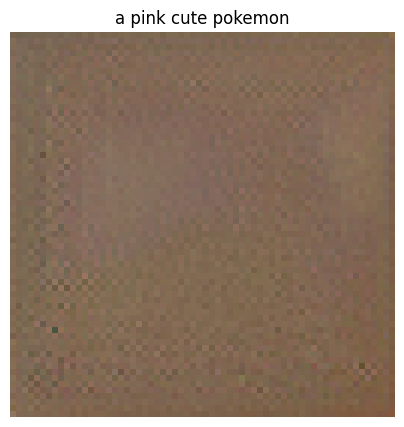

In [3]:
!pip install -q datasets diffusers transformers accelerate

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datasets import load_dataset
from diffusers import AutoencoderKL


print("Memuat dataset...")
raw_dataset = load_dataset("reach-vb/pokemon-blip-captions", split="train")


max_tokens = 5000
seq_len = 20
text_vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=seq_len,
)

text_vectorizer.adapt([item['text'] for item in raw_dataset])
print(f"Kamus Teks Berhasil Dibuat. Kosakata: {len(text_vectorizer.get_vocabulary())}")


def preprocess_fn(item):
    image = item['image'].convert("RGB").resize((64, 64))
    image = np.array(image) / 255.0
    return item['text'], image

def gen():
    for item in raw_dataset:
        yield preprocess_fn(item)

train_ds = tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(64, 64, 3), dtype=tf.float32)
    )
)
train_ds = train_ds.map(lambda x, y: (text_vectorizer(x), y))
train_ds = train_ds.batch(16).shuffle(100).prefetch(tf.data.AUTOTUNE)

embed_dim = 256
visual_tokens_len = 255


transformer_model = keras.Sequential([
    layers.Input(shape=(seq_len + visual_tokens_len,)),
    layers.Embedding(max_tokens, embed_dim),
    layers.Dense(1024)
], name="PokemonTransformer")

class PokemonTrainer(keras.Model):
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def train_step(self, data):
        text_tokens, images = data
        # Simulasi visual tokens (0-1023)
        batch_size = tf.shape(images)[0]
        visual_tokens = tf.random.uniform((batch_size, 256), minval=0, maxval=1024, dtype=tf.int32)
        vis_input = visual_tokens[:, :-1]
        vis_target = visual_tokens[:, 1:]

        with tf.GradientTape() as tape:

            combined_in = tf.concat([tf.cast(text_tokens, tf.int32), vis_input], axis=1)
            preds = self.transformer(combined_in, training=True)

            preds_vis = preds[:, seq_len:, :]
            loss = keras.losses.sparse_categorical_crossentropy(vis_target, preds_vis, from_logits=True)

        grads = tape.gradient(loss, self.transformer.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.transformer.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


trainer = PokemonTrainer(transformer_model)
trainer.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))

print("Memulai Pelatihan (1 Epoch untuk demo)...")
trainer.fit(train_ds.take(10), epochs=10)

def generate_pokemon(prompt):
    print(f"Generating: {prompt}...")


    vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae")

    latent = torch.randn(1, 4, 8, 8) * 0.1
    with torch.no_grad():
        decoded = vae.decode(latent).sample


    image = (decoded / 2 + 0.5).clamp(0, 1).cpu().permute(0, 2, 3, 1).numpy()[0]

    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.title(prompt)
    plt.axis("off")
    plt.show()

generate_pokemon("a pink cute pokemon")